**Models**:
- Binary Classifier (BC)
- Random Forest (RF)
- Neural Network (NN)

# Load Packages

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras import backend as K

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score

# Load Datasets and Basic Data Cleaning

## BC & RF: features dataset

In [ ]:
df_feature = pd.read_csv('~data/feature_extraction.csv')
df_feature = df_feature.dropna(how='all', subset=df_feature.columns[2:])
df_feature

## NN: sites_data.csv

In [3]:
sites_data = pd.read_csv("~data/sites_data_11x11.csv")
sites_data

,time,lat,lon,TUR,SPM,CHL,site
0,2022-03-01,55.189352,-1.519043,NaN,NaN,NaN,Newbiggin North
1,2022-03-01,55.189352,-1.517296,NaN,NaN,NaN,Newbiggin North
2,2022-03-01,55.189352,-1.515549,NaN,NaN,NaN,Newbiggin North
3,2022-03-01,55.189352,-1.513802,NaN,NaN,NaN,Newbiggin North
4,2022-03-01,55.189352,-1.512055,NaN,NaN,NaN,Newbiggin North
...,...,...,...,...,...,...,...
12331105,2022-10-31,50.277315,-3.893256,2.006134,1.186131,1.828091,Bigbury-on-Sea South
12331106,2022-10-31,50.277315,-3.891509,0.708182,0.406647,1.046769,Bigbury-on-Sea South
12331107,2022-10-31,50.277315,-3.889762,1.258156,0.729469,1.327342,Bigbury-on-Sea South
12331108,2022-10-31,50.277315,-3.888015,1.037095,0.598882,1.254974,Bigbury-on-Sea South


In [4]:
sites_data.isnull().sum()

time           0
lat            0
lon            0
TUR     10838900
SPM     10838900
CHL     10838900
site           0
dtype: int64

In [5]:
# Fill Null Values with 0, as we cannot have missing values in the tensors for neural network
# Later we will remove time, site pairs where all values are 0

sites_data.fillna(value=-10, inplace=True)

## All: Pollution Data

In [6]:
riskforecasting = pd.read_csv('~data/pollution_risk_forecasting.csv')
riskforecasting

,site,time,warning,riskLevelLabel
0,Ainsdale,2022-04-28,Pollution RIsk Forecasts will start soon,normal
1,Ainsdale,2022-04-29,Pollution RIsk Forecasts will start soon,normal
2,Ainsdale,2022-04-30,Pollution RIsk Forecasts will start soon,normal
3,Ainsdale,2022-05-04,No warnings in place,normal
4,Ainsdale,2022-05-05,No warnings in place,normal
...,...,...,...,...
63573,Yaverland,2022-09-26,No pollution incidents reported,normal
63574,Yaverland,2022-09-27,No pollution incidents reported,normal
63575,Yaverland,2022-09-28,No pollution incidents reported,normal
63576,Yaverland,2022-09-29,No pollution incidents reported,normal


# Data Manipulation and Further Data Cleaning

### Replace NaNs with mean

In [ ]:
def fill_na_values_with_mean(row, feature, dimensions):
    if pd.isnull(row).any():
        for dim in dimensions:
            if pd.isna(row[f"{feature}_{dim}x{dim}_median"]):
                available_medians = row[[f"{feature}_{i}x{i}_median" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_median"])]]
                row[f"{feature}_{dim}x{dim}_median"] = available_medians.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_mean"]):
                available_means = row[[f"{feature}_{i}x{i}_mean" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_mean"])]]
                row[f"{feature}_{dim}x{dim}_mean"] = available_means.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_q1"]):
                available_q1s = row[[f"{feature}_{i}x{i}_q1" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_q1"])]]
                row[f"{feature}_{dim}x{dim}_q1"] = available_q1s.mean()

            if pd.isna(row[f"{feature}_{dim}x{dim}_q3"]):
                available_q3s = row[[f"{feature}_{i}x{i}_q3" for i in dimensions if not pd.isna(row[f"{feature}_{i}x{i}_q3"])]]
                row[f"{feature}_{dim}x{dim}_q3"] = available_q3s.mean()
    return row

# apply the function to the DataFrame
dimensions = range(1, 12, 2)
df_feature_mean = df_feature
for feature in ["TUR", "SPM", "CHL"]:
    df_feature_mean = df_feature_mean.apply(fill_na_values_with_mean, axis=1, args=(feature, dimensions))
df_feature_mean

In [ ]:
df_merged = pd.merge(df_feature_mean, riskforecasting[['site', 'time', 'riskLevelLabel']], on=['site', 'time'])
df_merged

## BC:

In [ ]:
df = df_merged
df["riskLevelLabel"].replace({"normal": 0, "increased": 1}, inplace=True)

scaler = MinMaxScaler()
df.iloc[:, 2:-1] = scaler.fit_transform(df.iloc[:, 2:-1])
df

## NN: Combine Datasets to Create Input Dataset
For every site (430) and time (237), create a 11 x 11 x 3 tensor, each corresponding to one risk level label 

In [7]:
%%time
def chl_to_array(chl_values):
    # Not 100% sure if this reshapes according to lat/lon (though it does not matter if we perform the same operation every time?)
    return np.array(chl_values).reshape(11, 11)

def get_features_data(sites_data, features_list):
    '''
    input: 
        - sites_data (pd.DataFrame):
            - dataframe where each row contains feature values for a time, site and coordinate
        - features_list (list):
            - list of strings of features to use
            
    output:
        - features data (pd.DataFrame)
            - row: data for every time and site pair
            - column: features
            - entries: np.array of shape 11x11
    '''
    dfs = []
    for feature in features_list:
        df = pd.DataFrame(sites_data.groupby(['time', 'site'])[feature].apply(chl_to_array))
        dfs.append(df)
    input_data = reduce(lambda  left,right: pd.merge(left,right,on=['time', 'site'],how='outer'), dfs)
    
    return input_data

features_df = get_features_data(sites_data, ['TUR', 'SPM', 'CHL'])
features_df

CPU times: user 6.17 s, sys: 506 ms, total: 6.68 s
Wall time: 6.77 s


TUR   
time       site                                                                        
2022-03-01 Ainsdale                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  \
           Allonby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Allonby South           [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Amble Links             [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Anderby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
...                                                                              ...   
2022-10-31 Withernsea              [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Wolvercote Mill Stream  [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Woolacombe Village      [[5.9864016, 25.982555, -10.0, -10.0, -10.0, -...   
           Worthing                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Yaverland               [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   

                                                                                 SPM   
time       site                                                                        
2022-03-01 Ainsdale                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  \
           Allonby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Allonby South           [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Amble Links             [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Anderby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
...                                                                              ...   
2022-10-31 Withernsea              [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Wolvercote Mill Stream  [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Woolacombe Village      [[3.564524, 16.43204, -10.0, -10.0, -10.0, -10...   
           Worthing                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   
           Yaverland               [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...   

                                                                                 CHL  
time       site                                                                       
2022-03-01 Ainsdale                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Allonby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Allonby South           [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Amble Links             [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Anderby                 [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
...                                                                              ...  
2022-10-31 Withernsea              [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Wolvercote Mill Stream  [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Woolacombe Village      [[6.564089, 6.803925, -10.0, -10.0, -10.0, -10...  
           Worthing                [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  
           Yaverland               [[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...  

[101910 rows x 3 columns]

In [8]:
# Merging datasets. Merge on riskforecasting (only add CHL values if we have riskLevellabel)
input_data = features_df.merge(riskforecasting, how='right', left_on=['time', 'site'], right_on=['time', 'site'])

In [9]:
# Missing data check. 
# Data missing for 07-23 and 07-25 for all sites - No satellite data

input_data[input_data['CHL'].isnull()]['time'].value_counts()

time
2022-07-23    421
2022-07-25    421
2022-04-06      1
Name: count, dtype: int64

In [10]:
# Other missing values to look into - why do we have risk level labels but not satellite data when merging? Naming issue?

input_data[(input_data['CHL'].isnull()) & (input_data['time'] != '2022-07-23') & (input_data['time'] != '2022-07-25')]

,time,site,TUR,SPM,CHL,warning,riskLevelLabel
53163,2022-04-06,Summerleaze,NaN,NaN,NaN,Risk of reduced water quality due to sewage,increased


In [11]:
# Drop NA values for now as there are not that many of them
input_data.dropna(inplace=True)
input_data.shape

(62735, 7)

In [12]:
# Remove rows where everything is 0 (i.e. all missing values)
def has_nonzero(arr):
    return np.any(arr != -10)

input_data = input_data[input_data['CHL'].apply(has_nonzero)]
input_data

,time,site,TUR,SPM,CHL,warning,riskLevelLabel
1,2022-04-29,Ainsdale,"[[3.0191753, 4.718409, 18.93536, 31.146648, 17...","[[1.7733235, 2.7514145, 11.544017, 19.844542, ...","[[3.7512763, 5.389326, 19.847187, 21.874485, 5...",Pollution RIsk Forecasts will start soon,normal
3,2022-05-04,Ainsdale,"[[6.075095, 8.419083, 17.229292, 32.485336, 56...","[[3.7166793, 5.1792426, 10.841286, 22.20052, 5...","[[7.8970146, 8.904125, 19.88592, 23.188456, 5....",No warnings in place,normal
6,2022-05-07,Ainsdale,"[[7.0757475, 8.779541, 17.503372, 31.796015, 8...","[[4.3843403, 5.4292417, 11.049892, 21.979761, ...","[[7.3157673, 8.303483, 17.746412, 20.563904, 4...",No warnings in place,normal
11,2022-05-12,Ainsdale,"[[11.064278, 13.916054, 24.395746, 46.244003, ...","[[6.9718647, 8.925689, 15.609535, 33.33457, 68...","[[8.789717, 9.66038, 23.01165, 27.012566, 5.88...",No warnings in place,normal
13,2022-05-14,Ainsdale,"[[13.135989, 17.599348, 28.951145, 57.160267, ...","[[8.290485, 11.462988, 18.59951, 41.832813, 51...","[[9.688214, 10.983141, 27.479614, 32.686024, 6...",No warnings in place,normal
...,...,...,...,...,...,...,...
63555,2022-09-08,Yaverland,"[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...",No pollution incidents reported,normal
63560,2022-09-13,Yaverland,"[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...",No pollution incidents reported,normal
63565,2022-09-18,Yaverland,"[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...",No pollution incidents reported,normal
63570,2022-09-23,Yaverland,"[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...","[[-10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -1...",No pollution incidents reported,normal


# Train-Test Split
- Pick time-site pairs to use as train data and test data
- Potential for implementing cross validation

In [13]:
time_site_pairs = input_data[['time', 'site']]

# 80/20 split
time_site_pairs_test = time_site_pairs.sample(frac=.2, random_state=42)
time_site_pairs_test

,time,site
53796,2022-05-28,Tankerton
38563,2022-06-21,Porthluney
29452,2022-04-28,Margate The Bay
44371,2022-08-27,Scarborough North Bay
18572,2022-09-29,Fleetwood
...,...,...
4681,2022-09-28,Bournemouth Alum Chine
417,2022-08-25,Amble Links
12837,2022-09-26,Crackington Haven
49602,2022-07-03,Slapton Sands Torcross


In [14]:
time_site_pairs_train = time_site_pairs[~time_site_pairs.isin(time_site_pairs_test)].dropna()
time_site_pairs_train

,time,site
3,2022-05-04,Ainsdale
6,2022-05-07,Ainsdale
13,2022-05-14,Ainsdale
21,2022-05-22,Ainsdale
23,2022-05-24,Ainsdale
...,...,...
63532,2022-08-14,Yaverland
63537,2022-08-19,Yaverland
63546,2022-08-29,Yaverland
63565,2022-09-18,Yaverland


# Train & Test Models 
- Train on training time-site pairs
- Test on testing time-site pairs

## Baseline

In [ ]:
############################baseline############################
train_data = df.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
test_data = df.merge(time_site_pairs_train, on=['time', 'site'], how='inner')

# Calculate the ratio of the labels in the training set
label_ratio_train = train_data['riskLevelLabel'].value_counts(normalize=True).to_dict()

# Generate random predictions for the test set with the label ratio from the training set
num_test_samples = len(test_data)
random_predictions_test = np.random.choice(list(label_ratio_train.keys()), num_test_samples, p=list(label_ratio_train.values()))

# Calculate the accuracy of the random coin flip baseline for the test set
accuracy_test = np.mean(random_predictions_test == test_data['riskLevelLabel'])
print(f'Accuracy of baseline on test set: {accuracy_test:.2%}')

## BC

In [ ]:
# Train-test split
df_train = df.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

In [ ]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# variable selection using LASSO
logreg = LogisticRegression(penalty='l1', solver='liblinear')
logreg.fit(X_train_scaled, y_train)
model = SelectFromModel(logreg, prefit=True)
X_train_selected = model.transform(X_train_scaled)
X_test_selected = model.transform(X_test_scaled)

logreg_selected = LogisticRegression(max_iter=10000)
logreg_selected.fit(X_train_selected, y_train)
y_pred = logreg_selected.predict(X_test_selected)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

In [ ]:
def lg_model(x,y):
    lg_model = LogisticRegression(
        random_state = 100, #specify the random_state 
        solver = 'saga',
        n_jobs = -1 ,#use all cpu cores
        max_iter = 10000 #give more iteration for model to converge 
    )

    params = {'penalty': ['l1', 'l2'],# penalty term
              'C': (0.1, 1,10)} #λ 

    lg = GridSearchCV(lg_model, params, cv=5,scoring=make_scorer(f1_score, average='macro'))
    lg.fit(x, y)
    print(lg.best_score_)
    print('Best_parameters:',lg.best_params_)
    return lg.best_estimator_

In [ ]:
%%time
base_lg = lg_model(X_train,y_train)

##### ROC

In [ ]:
from sklearn.metrics import roc_curve
def draw_roc(model,X_test,y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
#scaling - based on training data
mean_train = X_train.mean() #compute the mean of training set
train_std = X_train.std() #compute the std of training set
scaled_X_train = (X_train-mean_train)/train_std
scaled_X_test = (X_test-mean_train)/train_std # to avoid bias, use the mean and std from training dataset and apply it on the testing dataset.

In [ ]:
draw_roc(base_lg, scaled_X_test, y_test)

In [ ]:
def training_cross_validation_score(model,x,y):
    accuray_scores = cross_val_score(model,x, y, scoring='accuracy', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    auc_scores = cross_val_score(model,x, y, scoring='roc_auc', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    f1_scores = cross_val_score(model,x, y, scoring='f1', cv=5, n_jobs=-1)# evaluate the model through 5 fold cross-validation
    print(str(model),'\naccuracy:',accuray_scores, '\naverage accuray:',accuray_scores.mean())
    print('\nauc score:', auc_scores,'\naverage auc score:',auc_scores.mean())
    print('\nf1 score:',f1_scores,'\naverage f1 score:',f1_scores.mean())

In [ ]:
%%time
training_cross_validation_score(base_lg, X_train,y_train)

In [ ]:
def test_evaluation(model,x,y):
    y_pred = model.predict(x)
    print(str(model),"\nOn test data,f1 score: %.2f "%f1_score(y, y_pred))
    print("On test data,Precision: %.2f" %precision_score(y, y_pred))
    print("Recall: %.2f" %recall_score(y, y_pred))
    acc = accuracy_score(y, y_pred)
    print("Accuracy: {:.2f} %".format(acc*100))
    ConfusionMatrixDisplay.from_estimator(model, x, y)

In [ ]:
test_evaluation(base_lg, scaled_X_test, y_test)

## RF

In [ ]:
# Train-test split
df_train = df_merged.merge(time_site_pairs_train, on=['time', 'site'], how='inner')
df_test = df_merged.merge(time_site_pairs_test, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_test = df_test


print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

In [ ]:
# fit a random forest to the data
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# make predictions
y_pred = rf.predict(X_test)

# evaluate the performance
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

- predict well with the 'normal' risk level but not with the 'increased'.

### Importance of Feature Aggregation

In [ ]:
importance_dict = dict(zip(df_train.columns, rf.feature_importances_))

features = ['11x11', '9x9', '7x7', '5x5', '3x3', '1x1', 'TUR', 'SPM', 'CHL']

data = []
for s in features:
    sum_importance = np.sum([importance for feature, importance in importance_dict.items() if s in feature])
    data.append([s, sum_importance])

# Create a DataFrame with the calculated data
df_importances = pd.DataFrame(data, columns=['Feature', 'Sum of Importances'])

def highlight_max(s):
    if len(s) > 3:
        return ['background-color: #DEB887' if v in list(s[np.argsort(s)[-3:]]) else '' for v in s]
    else:
        return ['background-color: #8FBC8F' if v == s.max() else '' for v in s]

df_importances[:6].style.apply(highlight_max, subset=['Sum of Importances'])

In [ ]:
df_importances[-3:].style.apply(highlight_max, subset=['Sum of Importances'])

### PCA

In [ ]:
pca_test = PCA(n_components=72)
pca_test.fit(X_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=5, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [ ]:
pca = PCA(n_components=10)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=df_train.columns, index=pca_dims)
pca_test_df.head(10).T

In [ ]:
# fit a random forest to the data
rf_pca = RandomForestClassifier()
rf_pca.fit(X_train_pca, y_train)

# make predictions
y_pred_pca = rf_pca.predict(X_test_pca)

# evaluate the performance
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_pca)
print(report)

## NN

### Helper Functions

In [107]:
def get_train_test_val_nn(input_data, train_labels, test_labels, dim = 11, oversampling = False, desired_pos_ratio =  0.5, train_val_ratio = 0.8):
    '''
    Gets train, test and validation datasets for a neural network model. 
    
    input: 
        - input_data (pd.DataFrame): 
            - dataframe of shape (m, n)
            - number of datapoints = m
            - features to consider = n-1
            - one of the columns = 'riskLevelLabel'
            
        - train_labels / test_labels (pd.DataFrame):
            - dataframe with two columns 'time' and 'site'
            - time and site pairs for train/test data
        
        - oversampling (boolean):
            - Whether oversampling should be performed

        - desired_pos_ratio (float):
            - desired ratio of positive samples when performing random oversampling

        - train_val_ratio (float):
            - ratio of training data to validation data
            
    output:
        - X_train (tensor)
        - X_test (tensor)
        - X_val (tensor)
        - y_train (np.array)
        - y_test (np.array)
        - y_val (np.array)
    '''
    train = pd.merge(train_labels, input_data, on=['time', 'site'])
    test = pd.merge(test_labels, input_data, on=['time', 'site'])
    
    # Changing window size
    i = int((dim-1)/2)
    
    def get_windowed_data(row):
        indices = np.array(range(1,122)).reshape(11,11)[5-i:6+i, 5-i:6+i].flatten()
        indices = [i-1 for i in indices]
        values = row.flatten()[[indices]].reshape(dim,dim)
        return values
    

    if dim != 11:
        train['CHL'] = train['CHL'].apply(get_windowed_data)
        train['TUR'] = train['TUR'].apply(get_windowed_data)
        train['SPM'] = train['SPM'].apply(get_windowed_data)
        test['CHL'] = test['CHL'].apply(get_windowed_data)
        test['TUR'] = test['TUR'].apply(get_windowed_data)
        test['SPM'] = test['SPM'].apply(get_windowed_data)
        
    # Getting X and y
    features_column_names = list(input_data.columns)
    for x in ['riskLevelLabel', 'time', 'site']:
        features_column_names.remove(x)
        
    X_train, X_test = train[features_column_names], test[features_column_names]
    y_train = np.array([1 if x == 'increased' else 0 for x in train['riskLevelLabel']])
    y_test = np.array([1 if x == 'increased' else 0 for x in test['riskLevelLabel']])
    
    # Oversampling for training data
    if oversampling:
        
        # Counting number of samples to oversample
        num_positives, num_negatives = sum(y_train), len(y_train)-sum(y_train)
        num_positives_to_repeat = int(desired_pos_ratio * num_negatives * 2) - num_positives
        
        # Oversampling
        ros = RandomOverSampler(sampling_strategy={1: num_positives_to_repeat}, random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
    # Reshape and Convert to Tensor
    # X_train
    if X_train.shape[1] == 1: 
        X_train = np.array([i for i in X_train[features_column_names[0]]])
        X_train = tf.convert_to_tensor(X_train)
        X_train = tf.expand_dims(X_train, axis=3, name=None)
    else:
        X_train = np.stack([np.stack(X_train[col].values) for col in X_train.columns], axis=1)
        X_train = np.transpose(X_train, (0, 2, 3, 1))
        X_train = tf.convert_to_tensor(X_train)
        
    # X_test
    if X_test.shape[1] == 1: 
        X_test = np.array([i for i in X_test[features_column_names[0]]])
        X_test = tf.convert_to_tensor(X_test)
        X_test = tf.expand_dims(X_test, axis=3, name=None)
    else:
        X_test = np.stack([np.stack(X_test[col].values) for col in X_test.columns], axis=1)
        X_test = np.transpose(X_test, (0, 2, 3, 1))
        X_test = tf.convert_to_tensor(X_test)
        
    X_train = tf.pad(X_train, [[0, 0], [16-i,15-i], [16-i,15-i], [0,0]])
    X_test = tf.pad(X_test, [[0, 0], [16-i,15-i], [16-i,15-i], [0,0]])
    
    # Train Validation Split
    i = int(X_train.shape[0] * train_val_ratio)
    X_val, y_val = X_train[i:], y_train[i:]
    X_train, y_train = X_train[:i], y_train[:i]
    
    return {'X_train': X_train, 
            'X_test': X_test, 
            'X_val': X_val, 
            'y_train': y_train, 
            'y_test': y_test,
            'y_val': y_val}    

In [90]:
def f1(y_true, y_pred):
    '''
    f1 score function for Keras
    '''
    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [91]:
def fit_nn(xy_data, model_type, metrics=['acc','AUC','Precision','Recall', f1], 
           loss='binary_crossentropy', optimizer='adam',
          batch_size=64, epochs=40):
    '''
    Fits a neural network model and returns history & evaluation metrics on test data.
    
    input:
        - xy_data: dictionary with X_train, X_test, X_val, y_train, y_test, y_val in this order (dict)
        - model_type: "baseline"/"convolution" (string)
        - loss: "binary_crossentropy" (string)
        - metrics: list of metrics to track. available metrics are: (list of string/function)
            - "acc"
            - "AUC"
            - "Precision"
            - "Recall"
            - f1
    '''
    # unpacking data
    X_train, X_test, X_val, y_train, y_test, y_val = xy_data.values()
    
    # building model
    model = models.Sequential()
    
    if model_type == "baseline":
        model.add(layers.Flatten(input_shape=X_train.shape[1:]))
        model.add(layers.Dense(100, activation='relu'))
        model.add(layers.Dense(1, activation="sigmoid"))
        
    elif model_type == "convolution":
        model.add(layers.Conv2D(filters=6, kernel_size=5, activation='relu', padding='same', input_shape=X_train.shape[1:]))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Conv2D(filters=16, kernel_size=5, activation='relu'))
        model.add(layers.AveragePooling2D(pool_size=2, strides=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(120, activation='relu')),
        model.add(layers.Dense(84, activation='relu')),
        model.add(layers.Dense(10, activation='relu')),
        model.add(layers.Dense(1, activation='sigmoid'))

    else:
        print('Model Type Undefined')
        
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    # Fit Model
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate Model
    result = model.evaluate(X_test, y_test)
    
    return history, result

In [92]:
def plot_train_val_loss(his, graph_title, ax):
    '''
    input:
        - history (keras.callbacks.History)
        - graph_title (string)
        - ax: plot location (tuple)
    output: 1 graph of train and validation loss across epochs
    '''
    axs[ax[0], ax[1]].plot(his.history['loss'])
    axs[ax[0], ax[1]].plot(his.history['val_loss'])
    axs[ax[0], ax[1]].title.set_text(f'{graph_title}')
    axs[ax[0], ax[1]].legend(['Training', 'Validation'])

def plot_train_val_metric(his, graph_title, ax, metric):
    '''
    input:
        - history (keras.callbacks.History)
        - graph_title (string)
        - ax: plot location (tuple)
        - metric: metric of interest (string)
    output: 1 graph of train and validation metric across epochs
    '''
    axs[ax[0], ax[1]].plot(his.history[f'{metric}'])
    axs[ax[0], ax[1]].plot(his.history[f'val_{metric}'])
    axs[ax[0], ax[1]].title.set_text(f'{graph_title}')
    axs[ax[0], ax[1]].legend(['Training', 'Validation'])

In [105]:
histories = []
results = []
print(datetime.now())

2023-05-11 18:57:09.131502


In [110]:
from IPython.display import clear_output

In [112]:
%%time

j = 0
for dim in [1,3,5,7,9,11]:
    
    # Getting Input Data
    input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]
        
    
    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           dim=dim)
    
    # Get history and result
    history, result = fit_nn(xy_data, "convolution")
    histories.append(history)
    results.append(result)
    
    j += 1
    clear_output(wait=True)
    print(f'Progress: {j}/6')
    print(datetime.now())

Progress: 6/6
2023-05-11 19:15:28.674704
CPU times: user 33min 52s, sys: 3min 34s, total: 37min 26s
Wall time: 7min 22s


In [116]:
results_ = results[:-6]
f1_scores = [i[5] for i in results_]
f1_scores

[0.0,
 0.0,
 0.015015012584626675,
 0.033633626997470856,
 0.048648640513420105,
 0.039639633148908615]

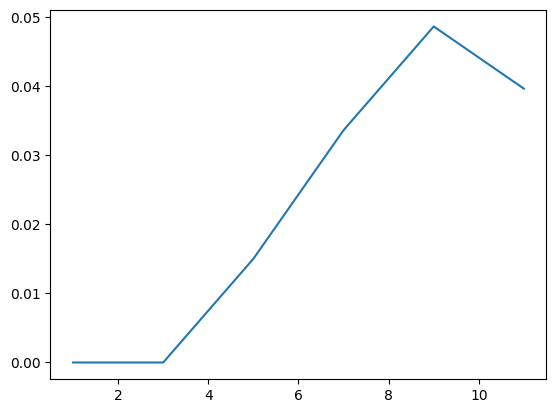

In [118]:
plt.plot([1,3,5,7,9,11], f1_scores)

In [100]:
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           oversampling = True)
xy_data['X_train'][0][0]

<tf.Tensor: shape=(32, 3), dtype=float64, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])>

In [103]:
input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]

train = pd.merge(time_site_pairs_train, input_data, on=['time', 'site'])

dim = 11

i = int((dim-1)/2)
def get_windowed_data(row):
    indices = np.array(range(1,122)).reshape(11,11)[5-i:6+i, 5-i:6+i].flatten()
    indices = [i-1 for i in indices]
    values = row.flatten()[[indices]].reshape(dim,dim)
    return values

train['CHL'] = train['CHL'].apply(get_windowed_data)
train['SPM'] = train['SPM'].apply(get_windowed_data)
train['TUR'] = train['TUR'].apply(get_windowed_data)

X_train = train[['CHL', 'TUR', 'SPM']]
# train['CHL'][0].flatten()[[indices]]

X_train = np.stack([np.stack(X_train[col].values) for col in X_train.columns], axis=1)
X_train = np.transpose(X_train, (0, 2, 3, 1))
X_train = tf.convert_to_tensor(X_train)


X_train = tf.pad(X_train, [[0, 0], [16-i,15-i], [16-i,15-i], [0,0]])

<tf.Tensor: shape=(32, 3), dtype=float64, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])>

### Get results for models

In [19]:
histories = []
results = []
print(datetime.now())

2023-05-11 18:08:39.283888


In [ ]:
%%time
import itertools
from IPython.display import clear_output

model_types = ["baseline", "convolution"]
num_features = [1,3]
oversampling_ = [True, False]
i = 0

for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
    
    # Getting Input Data
    if num_feature == 1:
        input_data_ = input_data[['CHL', 'riskLevelLabel', 'site', 'time']]
        
    elif num_feature == 3:
        input_data_ = input_data[['CHL', 'SPM', 'TUR', 'riskLevelLabel', 'site', 'time']]
        
    
    # Getting xy_data
    xy_data = get_train_test_val_nn(input_data_, 
                           time_site_pairs_train, 
                           time_site_pairs_test, 
                           oversampling = oversampling_)
    
    # Get history and result
    history, result = fit_nn(xy_data, model_type)
    histories.append(history)
    results.append(result)
    
    i += 1
    clear_output(wait=True)
    print(f'Progress: {i}/{len(model_types)*len(num_features)*len(oversampling_)}')
    print(datetime.now())

In [ ]:
model_names = []

for model_type, num_feature, oversampling__ in itertools.product(model_types, num_features, oversampling_):
    oversample = "Oversampling" if oversampling__ else "No Oversampling"
    model_names.append(f'{model_type.capitalize()}, {num_feature} feature, {oversample}')
    
df1 = pd.DataFrame(model_names, columns=['Sub-Model'])
df2 = pd.DataFrame(results, columns=['loss', 'acc','AUC','Precision','Recall', 'f1'])
results_df_nn = pd.concat([df1, df2], axis=1)
results_df_nn['Model'] = ['Neural Network']*8
results_df_nn

In [ ]:
model_names_string = model_names

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

for j in range(8):
    ax = ([(k,i) for k in range(4) for i in range(2)])[j]
    plot_train_val_loss(histories[j], model_names_string[j], ax)

plt.suptitle('Training Loss vs Validation Loss')
fig.supxlabel("Epochs")
fig.supylabel("Loss")
plt.show()

In [ ]:
metric='f1'

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 12), sharex=True, sharey=True)

for j in range(8):
    ax = ([(k,i) for k in range(4) for i in range(2)])[j]
    plot_train_val_metric(histories[j], model_names_string[j], ax, metric=metric)

plt.suptitle(f'Training {metric} vs Validation {metric}')
fig.supxlabel("Epochs")
fig.supylabel(f"{metric}")
plt.show()

# Final Results
Dummy / sketch dataframe (just as an example, sub-models and statistics tbc)

In [ ]:
results_df_nn_final = results_df_nn[['Model', 'Sub-Model', 'AUC','Precision','Recall','f1','acc']]
results_df_nn_final

In [ ]:
tuples = [('Baseline Random Guess', 'N/A'),
        ('BC', 'No oversampling, all features'),
         ('BC', 'No oversampling, top 10 features'),
         ('BC', 'Oversampling, all features'),
         ('BC', 'Oversampling, top 10 features'),
         ('RF', 'No oversampling'),
         ('RF', 'Oversampling'),
         ('NN', 'No oversampling'),
         ('NN', 'Oversampling')]

index = pd.MultiIndex.from_tuples(tuples, names=["Model", "Sub-Model"])

df = pd.DataFrame(columns = {'F1': [0,0,0,0,0,0,0,0,0], 
                            'Precision': [0,0,0,0,0,0,0,0,0],
                            'Recall': [0,0,0,0,0,0,0,0,0],
                            'AUC': [0,0,0,0,0,0,0,0,0], 
                            'Acc': [0,0,0,0,0,0,0,0,0]}, index = index)

df

# Window Size against F1 Plot

In [ ]:
# change tensor size: 1x1, 3x3, 5x5, 7x7, 9x9, 11x11
# run best NN model

